# Numerical assignment 2
If the .gif files do not display properly, see [github/willidu/TFY4215/numeric_2/animations](https://github.com/willidu/TFY4215/tree/main/numeric_2/animations)

In [8]:
import sys
sys.path.append('../..')

import numpy as np
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from numeric_1.schrodinger import schrodinger

In [9]:
"""
This module is for testing the orthonorma properties of stationary solutions to
the Schrödinger equation. Normality is checked in the solver from numeric_1,
so we only need to test the orthogonality of solutions.
"""

def main():
    x, dx = np.linspace(-20, +20, 400, retstep=True)

    potentials = [
        np.zeros_like(x),                                            # Infinite well
        x ** 2 / 4,                                                  # Harmonic oscillator
        np.piecewise(x, [np.abs(x) > 2, np.abs(x) <= 2], [0, -10]),  # Finite well
        np.random.rand(len(x))                                       # Random
    ]

    for psi in [schrodinger(v, dx)[1] for v in potentials]:

        assert np.allclose(
            np.transpose(psi) @ psi,
            np.identity(psi.shape[0])/dx
        ), 'Psi not orthogonal'

if __name__ == '__main__':
    main()

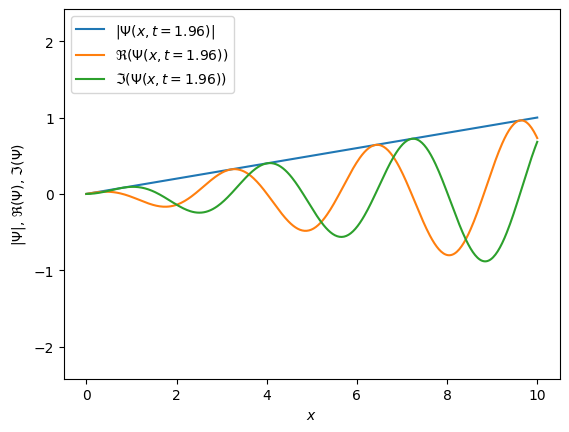

In [11]:
"""
This module is an extension of the solution to the first Numerical Assignment.
Animation function does not display potential :/
"""

def time_evolution(
        energy: np.ndarray, psi: np.ndarray, psi0: np.ndarray, dx: float
    ) -> Callable[[np.ndarray, int], np.ndarray]:
    """
    Parameters
    ----------
    energy : np.ndarray
        Eigenvalues from solving the time independent SE.
    psi : np.ndarray
        Eigenvectors from solving the time independent SE.
    psi0 : np.ndarray
        Wave function at t = 0.
    dx : float
        Distance between points

    Returns
    -------
    Psi(x, t) : Callable
        Time evolved function of position x and time t.
    """
    return lambda x, t: np.einsum('ij,i->j', psi, np.dot(psi, psi0) * dx * np.exp(-1j * energy * t))


def animate_wave(
        x: np.ndarray,
        time: float,
        psi: Callable[[np.ndarray, float], np.ndarray],  # x, t -> psi
        fps: int = 25,
        re: bool = False,
        im: bool = False,
        savepath: str = 'animation.gif'
    ) -> None:
    """
    Parameters
    ----------
    x : np.ndarray
        Positional array
    time : float
        Duration of animation in seconds
    psi : Callable[[np.ndarray, float], np.ndarray]
        Time evolved Psi(x, t)
    fps : int
        Frames per second. Default 25
    re, im : bool
        Turn on/off plotting for real and imag. parts of psi. Default false.
    savepath : string
        Path where animation is saved.
    """
    fig, ax = plt.subplots()

    ax.set_xlabel('$x$')
    ax.set_ylabel('$|\Psi|$, $\Re{(\Psi)}$, $\Im{(\Psi)}$')

    ymax = 1.1*np.max(np.abs(psi(x, t=0)))
    graph, = ax.plot([x[0], x[-1]], [0, 2 * ymax])
    if re:
        graph2, = ax.plot([x[0], x[-1]], [0, -2 * ymax])
    if im:
        graph3, = ax.plot([x[0], x[-1]], [0, -2 * ymax])

    time_step = 1. / fps

    def frame(i):
        time = i * time_step
        wave = psi(x, time)
        graph.set_data(x, np.abs(wave))
        graph.set_label(f'$|\Psi(x, t = {time:.2f})|$')
        if re:
            graph2.set_data(x, np.real(wave))
            graph2.set_label(f'$\Re(\Psi(x, t = {time:.2f}))$')
        if im:
            graph3.set_data(x, np.imag(wave))
            graph3.set_label(f'$\Im(\Psi(x, t = {time:.2f}))$')
        ax.legend(loc="upper left")

    FuncAnimation(fig, frame, frames=int(float(time)*fps), interval=time_step*1000, repeat=False).save(
        savepath, writer=PillowWriter(fps=fps)
    )


def main():
    """
    Example given in Jupyter
    """
    animate_wave(
        x = np.linspace(0, 10, 400),
        time = 2.,
        psi = lambda x, t: (x/np.max(x)) * np.exp(1j * x * t),
        re = True,
        im = True,
        savepath='../animations/example.gif'
    )

if __name__ == '__main__':
    main()


T = 1.70 s


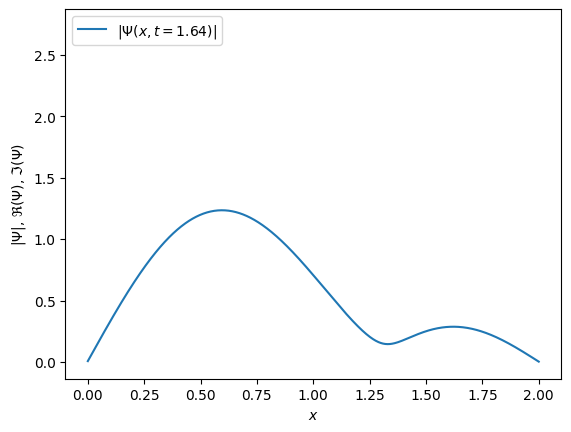

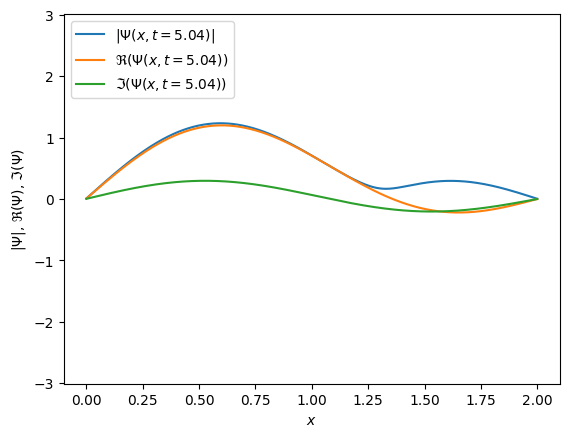

In [12]:
"""
This module shows the time evolution of a particle in a box with a superposition
of the ground state and first excited state.
"""

def psi0(psi):
    """
    Superposition of Psi0(x) and Psi1(x)
    """
    return (psi[0] + psi[1]) / np.sqrt(2)


def main():
    N = 1000
    box_length = 2.
    x, dx = np.linspace(0, box_length, N, retstep=True)
    potential = np.zeros_like(x)
    energy, psi = schrodinger(potential, dx)

    time_period = 2 * np.pi / (energy[1] - energy[0])  # [s]
    print(f'T = {time_period:.2f} s')

    animate_wave(
        x = x,
        time = time_period,
        psi = time_evolution(energy, psi, psi0(psi), dx),
        savepath='../animations/box_superpos.gif'
    )

    animate_wave(
        x = x,
        time = 3*time_period,
        psi = time_evolution(energy, psi, psi0(psi), dx),
        re = True,
        im = True,
        savepath='../animations/box_superpos_2.gif'
    )

if __name__ == '__main__':
    main()


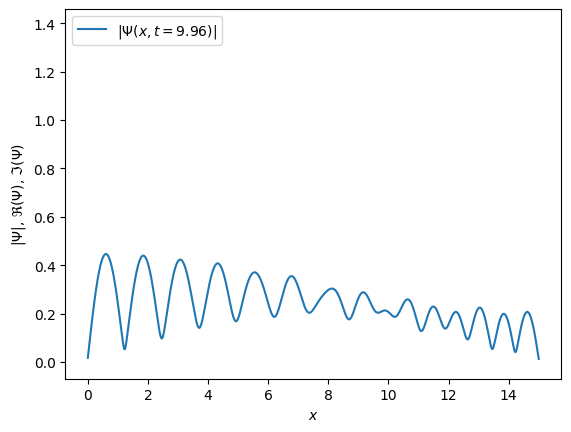

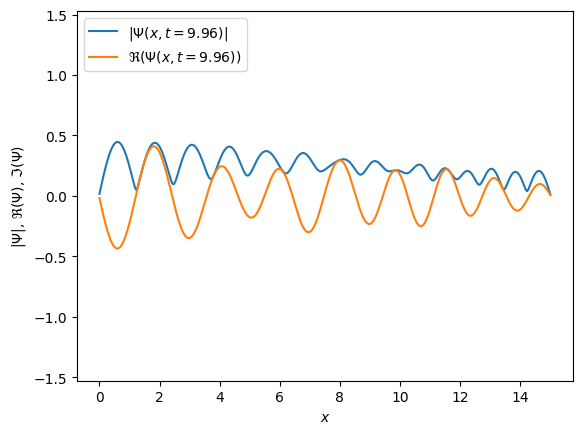

In [14]:
"""
This module visualizes an electron in an infinite well, representing a free electron by
a Gaussian wave packet.
"""

def psi0(x: np.ndarray, dx: float, x0: float = 0., p0: float = 0.) -> np.ndarray:
    """
    Gaussian wave packet Psi(x, t=0).

    Parameters
    ----------
    x : np.ndarray
        Position
    dx : float
        Uncertainty in x direction
    x0 : float
        Initial position. Default 0.
    p0 : float
        Initial momentum. Default 0.
    """
    return np.exp(-(x - x0) ** 2 / (4 * dx ** 2)) \
        * np.exp(1j * p0 * x) \
        / (2 * np.pi * dx ** 2) ** (1 / 4)


def main():
    N = 1000
    x, dx = np.linspace(0, 15, N, retstep=True)
    potential = np.zeros_like(x)
    energy, psi = schrodinger(potential, dx)

    animate_wave(
        x = x,
        time = 10.,
        psi = time_evolution(energy, psi, psi0(x, dx=1., x0=5, p0=3.), dx),
        savepath='../animations/wavepkg.gif'
    )

    animate_wave(
        x = x,
        time = 10.,
        psi = time_evolution(energy, psi, psi0(x, dx=1., x0=5, p0=3.), dx),
        re = True,
        savepath='../animations/wavepkg_2.gif'
    )

if __name__ == '__main__':
    main()


Before the wave packet hits the right wall, its amplitude decrease while its width increase. When it collides with the wall, it reflects while continuing to increase in width. After it collides with the left wall, it starts to interfere with itself.

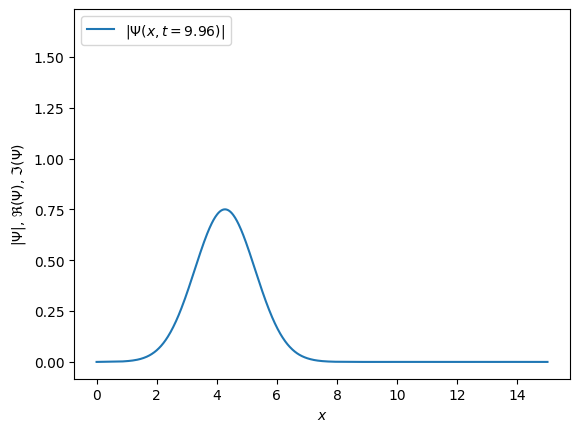

In [16]:
"""
This module visualizes an electron in an harmonic oscillator.
Uses m = omega = hbar = 1.
"""

def V(x: float | np.ndarray, L: float = 1.) -> float | np.ndarray:
    """
    Potential of oscillator. Centered around L/2.
    """
    return (x - L/2) ** 2 / 2.


def psi0(x: np.ndarray, x0: float = 0.) -> np.ndarray:
    """
    Translated stationary state wave Psi(x, t=0).
    """
    return np.power(np.pi, -1/4) * np.exp((-(x - x0) ** 2) / 2.)


def main():
    N = 1000
    box_length = 15.
    x, dx = np.linspace(0, box_length, N, retstep=True)
    energy, psi = schrodinger(V(x, L=box_length), dx)

    animate_wave(
        x = x,
        time = 10.,
        psi = time_evolution(energy, psi, psi0(x, x0=0.75*box_length), dx),
        savepath='../animations/harm.gif'
    )

if __name__ == '__main__':
    main()


The wave oscillates harmonically between the boundaries of the potential. Since the potential is smooth and quadratic, it can approximate a harmonic potential in the classical sense.

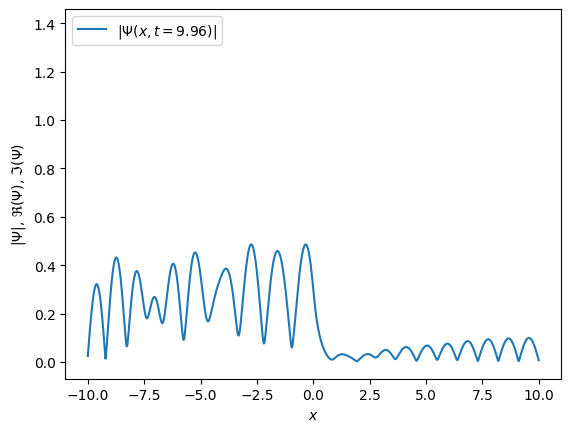

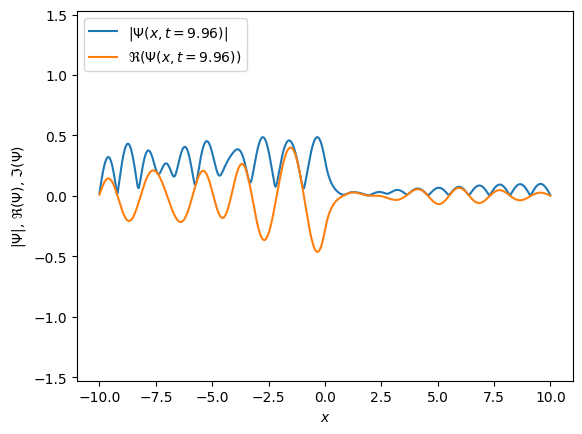

In [18]:
"""
This module visualizes the transmittion and reflection of an electron
when colloding with a potential barrier.
"""

def V(x):
    """
    Potential barrier. V(x) = 1 for x in (0, 1).
    """
    return np.where(np.logical_and(x > 0, x < 1), 10, 0)


def psi0(x: np.ndarray, dx: float, x0: float = 0., p0: float = 0.) -> np.ndarray:
    """
    Gaussian wave packet Psi(x, t=0).

    Parameters
    ----------
    x : np.ndarray
        Position
    dx : float
        Uncertainty in x direction
    x0 : float
        Initial position. Default 0.
    p0 : float
        Initial momentum. Default 0.
    """
    return np.exp(-(x - x0) ** 2 / (4 * dx ** 2)) \
        * np.exp(1j * p0 * x) \
        / (2 * np.pi * dx ** 2) ** (1 / 4)


def main():
    N = 1000
    x, dx = np.linspace(-10, 10, N, retstep=True)
    energy, psi = schrodinger(V(x), dx)

    animate_wave(
        x = x,
        time = 10.,
        psi = time_evolution(energy, psi, psi0(x, dx=1., x0=-5, p0=3.), dx),
        savepath='../animations/pot_barrier.gif'
    )

    animate_wave(
        x = x,
        time = 10.,
        psi = time_evolution(energy, psi, psi0(x, dx=1., x0=-5, p0=3.), dx),
        re=True,
        savepath='../animations/pot_barrier_2.gif'
    )

if __name__ == '__main__':
    main()
